In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
import os

In [1]:
import re
import nltk
import string
from nltk import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import spacy


from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm

In [5]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\petra.kibugu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\petra.kibugu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\petra.kibugu\AppData\Roaming\nltk_data...


True

In [6]:
data = pd.read_csv("judge-1377884607_tweet_product_company.csv", encoding='unicode_escape')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<AxesSubplot:xlabel='is_there_an_emotion_directed_at_a_brand_or_product', ylabel='count'>

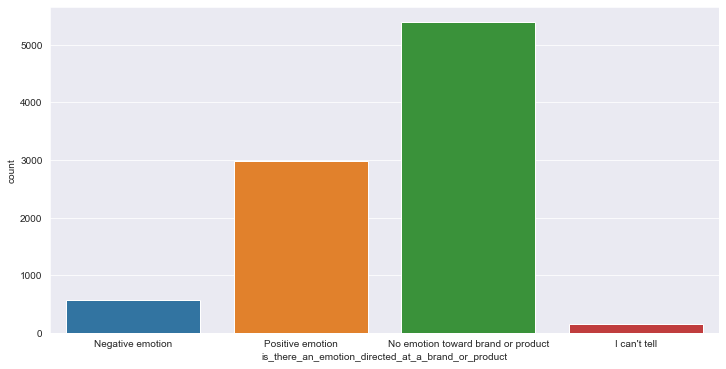

In [7]:
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=data)

There are altogether four sentiment classes in which neutral type of emotion ('No emotion...') is more prevalent. We can also see the sentiment 'I can't tell' constitutes only tiny portion of the data. Sentiment wise, this might be closer to the neutral type in which case we may  combine this to the neutral class. However, this class is already a majority class which is already causing huge imbalance in the dataset. So, we will drop the data with this class label.

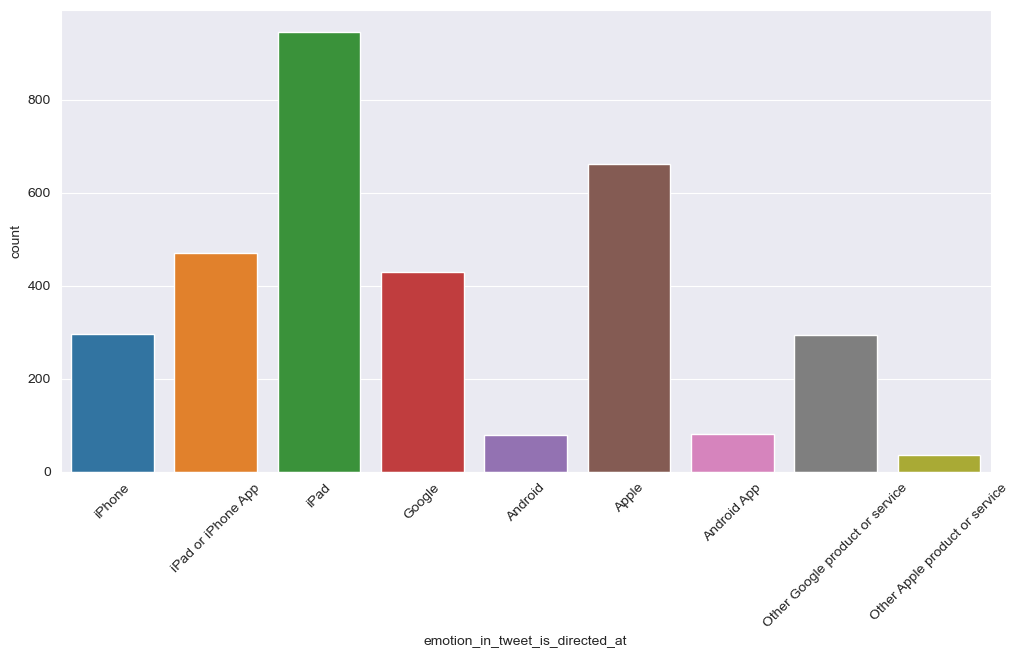

In [10]:
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='emotion_in_tweet_is_directed_at', data=data)
plt.xticks(rotation=45);

The tweet data are dispersed into several brands under Apple and Google. We will consolidate these information into these two major brands.

### Data Preparation

In [11]:
# Create a working dataframe with easier column name
df = data.copy(deep=True)
df.drop_duplicates(subset=['tweet_text'], inplace=True)
df.dropna(subset=['tweet_text'], inplace=True)
df.rename(columns = {'emotion_in_tweet_is_directed_at':'brand_item', 'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace=True)

# Convert the data types to string
df['tweet_text'] = df['tweet_text'].astype(str)
df['brand_item'] = df['brand_item'].astype(str)

# Brand name mapping
brand = {'iPhone': 'apple',
         'iPad or iPhone App':'apple',
         'iPad': 'apple',
         'Google': 'google',
         'nan': 'UNK',
         'Android':'google',
         'Apple': 'apple',
         'Android App':'google',
         'Other Google product or service':'google',
         'Other Apple product or service':'apple'
        }

df['brand_name'] = df['brand_item'].map(brand)

# Encoding class label to brief
label_encoder = {'Negative emotion': 'negative',
                 'Positive emotion': 'positive',
                 'No emotion toward brand or product': 'neutral',
                 "I can't tell":'confused'}

df['emotion'] = df['emotion'].map(label_encoder)
df = df[df['emotion'] != 'confused']    # drop the rows containing 'confused' labels

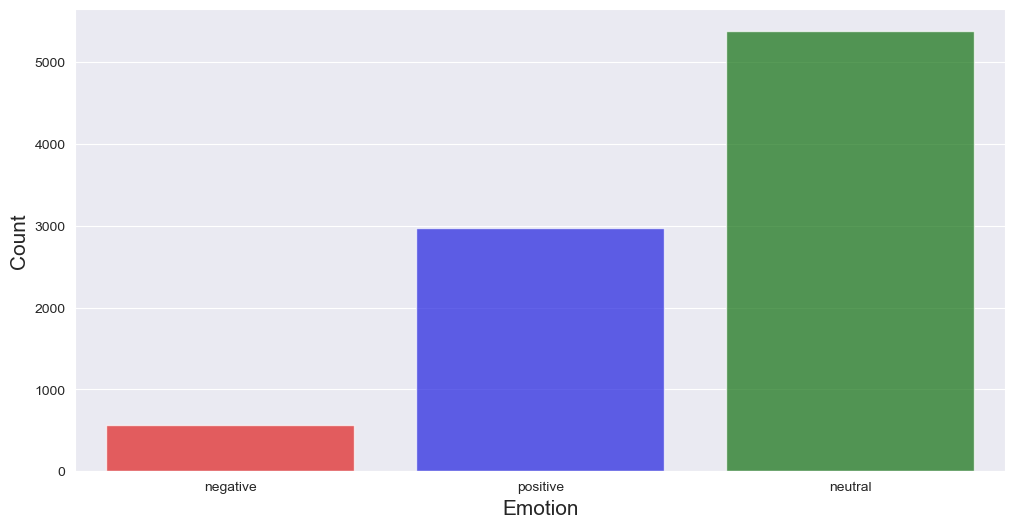

In [12]:
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='emotion', data=df,  
              palette={'positive':'b', 'negative':'r', 'neutral':'g'}, alpha=0.7)
plt.xlabel('Emotion', fontsize=15)
plt.ylabel('Count', fontsize=15);

In [13]:
df.emotion.value_counts(normalize=True)

emotion
neutral     0.602986
positive    0.333146
negative    0.063868
Name: proportion, dtype: float64

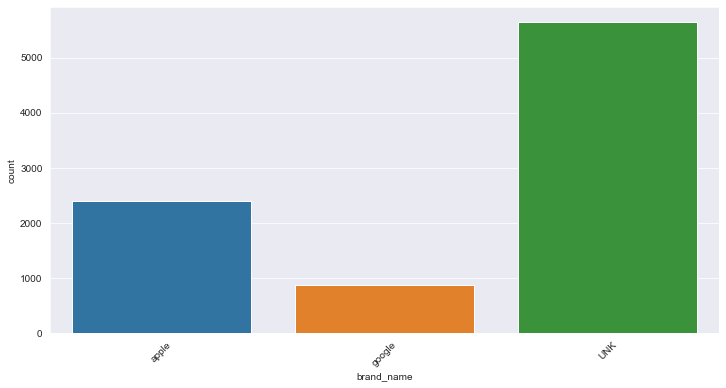

In [11]:
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='brand_name', data=df)
plt.xticks(rotation=45);

We can see, the number of tweets associated with the Apple is far greater than Google. So, we will need to use a % difference between these two brands when comparing against one another.

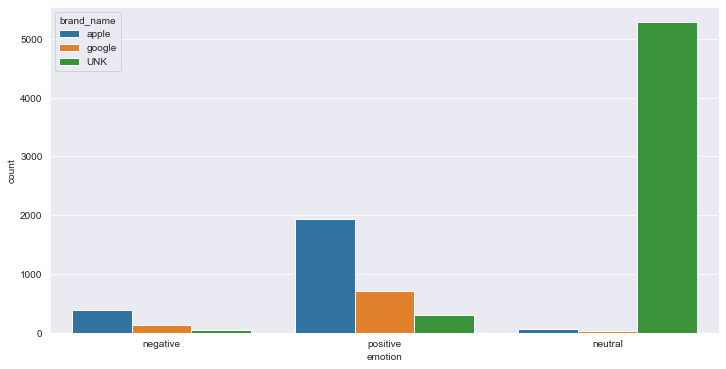

In [12]:
plt.figure(figsize=(12,6))
ax = sns.countplot(data=df, x = 'emotion', hue='brand_name')

### Data Augmentation

We can see there is a huge imbalance in the class label, especially the proportion of negative emotion is significantly low. In the next data we will add few rows of data with negative class label from a different twitter dataset. The dataset is mainly about he Apple product.

In [13]:
df = df[['emotion', 'tweet_text']]
df.head()

,emotion,tweet_text
0,negative,.@wesley83 I have a 3G iPhone. After 3 hrs twe...
1,positive,@jessedee Know about @fludapp ? Awesome iPad/i...
2,positive,@swonderlin Can not wait for #iPad 2 also. The...
3,negative,@sxsw I hope this year's festival isn't as cra...
4,positive,@sxtxstate great stuff on Fri #SXSW: Marissa M...


In [15]:
data2 = pd.read_csv("Apple-Twitter-Sentiment-DFE.csv", encoding='unicode_escape')

data2 = data2.loc[:, ('sentiment', 'text')].astype(str)
data2_neg = data2.loc[data2['sentiment']=='1']
data2_neg['sentiment'] = data2_neg.loc[:, ('sentiment')].apply(lambda x: 'negative')
data2_neg.rename(columns = {'sentiment':'emotion', 'text':'tweet_text'}, inplace=True)

C:\Users\petra.kibugu\AppData\Local\Temp\ipykernel_33156\1585217901.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_neg['sentiment'] = data2_neg.loc[:, ('sentiment')].apply(lambda x: 'negative')
C:\Users\petra.kibugu\AppData\Local\Temp\ipykernel_33156\1585217901.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_neg.rename(columns = {'sentiment':'emotion', 'text':'tweet_text'}, inplace=True)


In [16]:
data2_neg

,emotion,tweet_text
10,negative,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
14,negative,@apple Contact sync between Yosemite and iOS8 ...
16,negative,WARNING IF YOU BUY AN IPHONE 5S UNLOCKED FROM ...
23,negative,"@Apple, For the love of GAWD, CENTER the '1'on..."
24,negative,i get the storage almost full notification lit...
...,...,...
3855,negative,RT @Ecofantasy: Thinking of upgrading to #Yose...
3857,negative,why isnt group facetime a thing @apple wtf
3877,negative,Being held hostage at @apple - They are replac...
3880,negative,hey @apple is it normal for my laptop charger ...


In [18]:
df = pd.concat([df, data2_neg], ignore_index=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10128 entries, 0 to 10127
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  10128 non-null  object
 1   brand_item  8909 non-null   object
 2   emotion     10128 non-null  object
 3   brand_name  8909 non-null   object
dtypes: object(4)
memory usage: 316.6+ KB


Text(0, 0.5, 'Count')

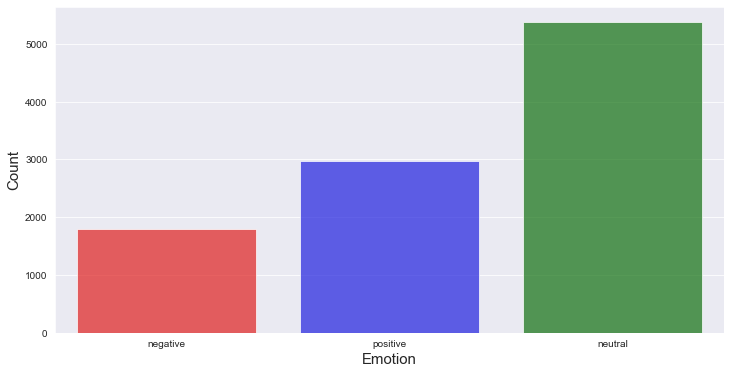

In [18]:
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='emotion', data=df,
             palette={'positive':'b', 'negative':'r', 'neutral':'g'}, alpha=0.7)
plt.xlabel('Emotion', fontsize=15)
plt.ylabel('Count', fontsize=15)

In [20]:
df.emotion.value_counts(normalize=True)

emotion
neutral     0.530411
positive    0.293049
negative    0.176540
Name: proportion, dtype: float64

### Text Preprocessing

Before we start modeling, it is important to clean up the text data which may contain too many unnecessary letters, symbols. Let's check few example of current text in the data.

In [21]:
df.tweet_text.head(10)

0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for #iPad 2 also. The...
3    @sxsw I hope this year's festival isn't as cra...
4    @sxtxstate great stuff on Fri #SXSW: Marissa M...
5    @teachntech00 New iPad Apps For #SpeechTherapy...
6    #SXSW is just starting, #CTIA is around the co...
7    Beautifully smart and simple idea RT @madebyma...
8    Counting down the days to #sxsw plus strong Ca...
9    Excited to meet the @samsungmobileus at #sxsw ...
Name: tweet_text, dtype: object

Punctuation is one of the major problem in text analysis, so it needs to be removed from the text. However, sometime it may affect the words such as: 'you're, I've,...' because it will basically try to remove the letter around apostrophe, and thus altering the context. Below, we will implement a detail contraction mapping such that contracted words are expanded to theirs full form.

In [22]:
contraction_map = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

In [23]:
def contraction_mapping(text):
    '''
    Function to map contraction to the text.
    '''   

    apostrophe_handled = re.sub("’", "'", text)
    expanded = ' '.join([contraction_map[t] if t in contraction_map else t for t in apostrophe_handled.split(" ")])
    

    return expanded

In [124]:
# Test the function
row = 10
print('Before contraction:', '\n',  df['tweet_text'][row])
print('\nAfter contraction:', '\n', contraction_mapping(df['tweet_text'][row]))

Before contraction: 
 Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I can't wait til the Android app comes out.

After contraction: 
 Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I cannot wait til the Android app comes out.


In [25]:
# Apply contraction mapping
df['expanded_tweets'] = df['tweet_text'].apply(contraction_mapping)

In [26]:
def tweet_cleaner(tweet):
    '''
    Function to remove punctuations, special characters, html links, twitter handels etc...
    '''
    
    stopwords = ['rt','rts', 'retweet', 'quot', 'sxsw']
    
    punctuation = set(string.punctuation) # punctuation of English language
    punctuation.remove('#') # remove # so hashtags remain in x
    
    x = tweet
    x = re.sub(r'https?:\/\/\S+', '', x) # remove URL references
    x = re.sub(r'{link}', '', x)  # remove placeholders
    x = re.sub(r'@[\w]*', '', x) # remove @mention users
    x = re.sub('[^A-Za-z0-9]+', ' ', x) # remove @mention users
    x = re.sub(r'\b[0-9]+\b', '', x) # remove stand-alone numbers  
    x = re.sub(r'&[a-z]+;', '', x) # remove HTML reference characters
    x = ''.join(ch for ch in x if ch not in punctuation) # remove punctuation
    x = x.replace("[^a-zA-z#]", " ")  #remove special characters

    x = [word.lower() for word in x.split() if word.lower() not in stopwords]
    x = [w for w in x if len(w)>2]

    return ' '.join(x)

In [125]:
# Test the function
row = 10
print('Before cleanup:', '\n',  df['expanded_tweets'][row])
print('\nAfter cleanup:', '\n', tweet_cleaner(df['expanded_tweets'][row]))

Before cleanup: 
 Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I cannot wait til the Android app comes out.

After cleanup: 
 find amp start impromptu parties with cannot wait til the android app comes out


In [28]:
# Apply the tweet cleaner to whole dataframe  
df['clean_tweets1'] = df['expanded_tweets'].apply(tweet_cleaner)

# Word count of all the vocabulary
FreqDist(df['clean_tweets1'].unique().sum().split())

FreqDist({'the': 3574, 'for': 2021, 'ipad': 1674, 'apple': 1570, 'google': 1406, 'and': 1400, 'iphone': 1207, 'store': 1071, 'you': 867, 'not': 762, ...})

We can see the word 'the' is the most common word. While for architecture like LSTM, we might need to retain these kinds of stopwords, but the more simple models like Naive Bayes, we would like to get rid of these words. So, we will create another set of words particularly to train Naive Bayes like algorithms.

In [29]:
def remove_stopwords(tweet):      
    stopwords_removed = [word for word in tweet.split() if word not in stopwords.words('english')]
    return ' '.join(stopwords_removed)                         

In [30]:
# Apply the tweet cleaner to whole dataframe  
df['clean_tweets2'] = df['clean_tweets1'].apply(remove_stopwords)

# Word count of all the vocabulary
FreqDist(df['clean_tweets2'].unique().sum().split())

FreqDist({'ipad': 1588, 'apple': 1493, 'google': 1315, 'iphone': 1142, 'store': 1042, 'new': 693, 'amp': 622, 'austin': 601, 'app': 571, 'pop': 453, ...})

In [31]:
df

,tweet_text,brand_item,emotion,brand_name,expanded_tweets,clean_tweets1,clean_tweets2
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,apple,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,have iphone after hrs tweeting rise austin was...,iphone hrs tweeting rise austin dead need upgr...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,apple,@jessedee Know about @fludapp ? Awesome iPad/i...,know about awesome ipad iphone app that you wi...,know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,apple,@swonderlin Can not wait for #iPad 2 also. The...,can not wait for ipad also they should sale th...,wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,apple,@sxsw I hope this year's festival is not as cr...,hope this year festival not crashy this year i...,hope year festival crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,google,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri marissa mayer google tim reill...,great stuff fri marissa mayer google tim reill...
...,...,...,...,...,...,...,...
10123,RT @Ecofantasy: Thinking of upgrading to #Yose...,NaN,negative,NaN,RT @Ecofantasy: Thinking of upgrading to #Yose...,thinking upgrading yosemite think twice not fo...,thinking upgrading yosemite think twice everyo...
10124,why isnt group facetime a thing @apple wtf,NaN,negative,NaN,why isnt group facetime a thing @apple wtf,why isnt group facetime thing wtf,isnt group facetime thing wtf
10125,Being held hostage at @apple - They are replac...,NaN,negative,NaN,Being held hostage at @apple - They are replac...,being held hostage they are replacing the whol...,held hostage replacing whole phone last backup...
10126,hey @apple is it normal for my laptop charger ...,NaN,negative,NaN,hey @apple is it normal for my laptop charger ...,hey normal for laptop charger soldering itself...,hey normal laptop charger soldering skin thanks


In [32]:
def normalization(tweet):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet.split():
        normalized_text = lem.lemmatize(word, 'v')
        normalized_tweet.append(normalized_text)
    return ' '.join(normalized_tweet)

In [33]:
# Apply the tweet cleaner to whole dataframe  
df['clean_tweets3'] = df['clean_tweets2'].apply(normalization)

# Word count of all the vocabulary
FreqDist(df['clean_tweets3'].unique().sum().split())

FreqDist({'ipad': 1586, 'apple': 1492, 'google': 1314, 'iphone': 1141, 'store': 1077, 'new': 691, 'amp': 619, 'austin': 601, 'app': 570, 'get': 526, ...})

In [34]:
df

,tweet_text,brand_item,emotion,brand_name,expanded_tweets,clean_tweets1,clean_tweets2,clean_tweets3
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,apple,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,have iphone after hrs tweeting rise austin was...,iphone hrs tweeting rise austin dead need upgr...,iphone hrs tweet rise austin dead need upgrade...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,apple,@jessedee Know about @fludapp ? Awesome iPad/i...,know about awesome ipad iphone app that you wi...,know awesome ipad iphone app likely appreciate...,know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,apple,@swonderlin Can not wait for #iPad 2 also. The...,can not wait for ipad also they should sale th...,wait ipad also sale,wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,apple,@sxsw I hope this year's festival is not as cr...,hope this year festival not crashy this year i...,hope year festival crashy year iphone app,hope year festival crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,google,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri marissa mayer google tim reill...,great stuff fri marissa mayer google tim reill...,great stuff fri marissa mayer google tim reill...
...,...,...,...,...,...,...,...,...
10123,RT @Ecofantasy: Thinking of upgrading to #Yose...,NaN,negative,NaN,RT @Ecofantasy: Thinking of upgrading to #Yose...,thinking upgrading yosemite think twice not fo...,thinking upgrading yosemite think twice everyo...,think upgrade yosemite think twice everyone asmsg
10124,why isnt group facetime a thing @apple wtf,NaN,negative,NaN,why isnt group facetime a thing @apple wtf,why isnt group facetime thing wtf,isnt group facetime thing wtf,isnt group facetime thing wtf
10125,Being held hostage at @apple - They are replac...,NaN,negative,NaN,Being held hostage at @apple - They are replac...,being held hostage they are replacing the whol...,held hostage replacing whole phone last backup...,hold hostage replace whole phone last backup m...
10126,hey @apple is it normal for my laptop charger ...,NaN,negative,NaN,hey @apple is it normal for my laptop charger ...,hey normal for laptop charger soldering itself...,hey normal laptop charger soldering skin thanks,hey normal laptop charger solder skin thank


## Modeling
We will start with simple scikit learn modeling. We will test Naive Bayes on tweets with and without lemmatization

In [35]:
X = df[['clean_tweets2']] 
y = df['emotion']

#### We will take aside 10% of data for Test Set, and further split training data into validation set

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train,
                                                  random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((7747, 1), (1368, 1), (1013, 1), (7747,), (1368,), (1013,))

In [37]:
# Vectorizing
tfidf_vectorizer = TfidfVectorizer()

X_train_vec = tfidf_vectorizer.fit_transform(X_train['clean_tweets2']).toarray()
X_test_vec = tfidf_vectorizer.transform(X_test['clean_tweets2']).toarray()
X_val_vec = tfidf_vectorizer.transform(X_val['clean_tweets2']).toarray()

In [38]:
X_train_vec.shape, X_val_vec.shape

((7747, 8878), (1368, 8878))

In [39]:
X_train

,clean_tweets2
1024,retiring wine library moving onto daily grape ...
7799,saw going download groundlink app amp ride lim...
5252,social apps make intimate sxswi apps iphone
5692,google announces check ins coupons deals
4877,digging john mcree talk designing boomers mayb...
...,...
6474,texas observer tomlinson says would double rev...
3492,think got bought something apple assumes apple...
4469,iphone find one gadget going bag
7055,missed touchingstories catch web touching stor...


In [40]:
# Simple Naive Bayes classifer 
clf1_NB = MultinomialNB()
clf1_NB.fit(X_train_vec, y_train)

MultinomialNB()

In [41]:
def get_prediction(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print('Training Prediction')
    print('--------------------')
    print(classification_report(y_train, y_train_pred))
    print('Test Prediction')
    print('--------------------')
    print(classification_report(y_test, y_test_pred))
    
    return y_train_pred, y_test_pred

In [42]:
_, _ = get_prediction(clf1_NB, X_train_vec, X_val_vec, y_train, y_val)

Training Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.99      0.61      0.76      1368
     neutral       0.71      0.98      0.83      4109
    positive       0.90      0.48      0.63      2270

    accuracy                           0.77      7747
   macro avg       0.87      0.69      0.74      7747
weighted avg       0.82      0.77      0.76      7747

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.96      0.45      0.61       241
     neutral       0.62      0.94      0.74       726
    positive       0.66      0.24      0.36       401

    accuracy                           0.65      1368
   macro avg       0.75      0.54      0.57      1368
weighted avg       0.69      0.65      0.61      1368



In [43]:
# Instantiate a Random Forest Classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=6, class_weight='balanced')
clf_rf.fit(X_train_vec, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=6, random_state=0)

In [44]:
_, _ = get_prediction(clf_rf, X_train_vec, X_val_vec, y_train, y_val)

Training Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.97      1.00      0.98      1368
     neutral       0.98      0.95      0.96      4109
    positive       0.93      0.96      0.94      2270

    accuracy                           0.96      7747
   macro avg       0.96      0.97      0.96      7747
weighted avg       0.96      0.96      0.96      7747

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.82      0.68      0.74       241
     neutral       0.69      0.83      0.76       726
    positive       0.65      0.47      0.54       401

    accuracy                           0.70      1368
   macro avg       0.72      0.66      0.68      1368
weighted avg       0.70      0.70      0.69      1368



In [45]:
# Next we try to fit Naive Bayes on lemmatized data
X = df[['clean_tweets3']] 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train,
                                                  random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((7747, 1), (1368, 1), (1013, 1), (7747,), (1368,), (1013,))

In [47]:
# Vectorizing
tfidf_vectorizer = TfidfVectorizer()

X_train_vec = tfidf_vectorizer.fit_transform(X_train['clean_tweets3']).toarray()
X_test_vec = tfidf_vectorizer.transform(X_test['clean_tweets3']).toarray()
X_val_vec = tfidf_vectorizer.transform(X_val['clean_tweets3']).toarray()

In [48]:
# Simple Naive Bayes classifer 
clf2_NB = MultinomialNB()
clf2_NB.fit(X_train_vec, y_train)

MultinomialNB()

In [358]:
_, _ = get_prediction(clf2_NB, X_train_vec, X_val_vec, y_train, y_val)

Training Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.99      0.60      0.75      1368
     neutral       0.70      0.98      0.82      4109
    positive       0.89      0.44      0.58      2270

    accuracy                           0.76      7747
   macro avg       0.86      0.67      0.72      7747
weighted avg       0.80      0.76      0.74      7747

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.96      0.46      0.62       241
     neutral       0.61      0.93      0.74       726
    positive       0.62      0.24      0.34       401

    accuracy                           0.64      1368
   macro avg       0.73      0.54      0.57      1368
weighted avg       0.68      0.64      0.60      1368



In [49]:
# Instantiate a Random Forest Classifier
clf_rf2 = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=6)
clf_rf2.fit(X_train_vec, y_train)

RandomForestClassifier(n_jobs=6, random_state=0)

In [50]:
_, _ = get_prediction(clf_rf2, X_train_vec, X_val_vec, y_train, y_val)

Training Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.99      0.98      0.99      1368
     neutral       0.95      0.98      0.96      4109
    positive       0.96      0.92      0.94      2270

    accuracy                           0.96      7747
   macro avg       0.97      0.96      0.96      7747
weighted avg       0.96      0.96      0.96      7747

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.83      0.67      0.74       241
     neutral       0.67      0.86      0.76       726
    positive       0.66      0.40      0.50       401

    accuracy                           0.69      1368
   macro avg       0.72      0.65      0.67      1368
weighted avg       0.70      0.69      0.68      1368



We do not see any major improvement when using lemmatized data for both Naive Bayes and Random Forest. However, the  accuracy result is a good baseline for any text classification. Next we will test Neural Network based classification using LSTM and GRU. 

## Neural Networks

In [51]:
import warnings
warnings.filterwarnings('ignore')

#### One-hot-encoding
One of the requirement for Tensorflow is that our output class label needs to be one-hot encoded.

In [52]:
X = df['clean_tweets1']
y_ohe = pd.get_dummies(df['emotion'])
print(X.iloc[:3], y_ohe.iloc[:3])

0    have iphone after hrs tweeting rise austin was...
1    know about awesome ipad iphone app that you wi...
2    can not wait for ipad also they should sale th...
Name: clean_tweets1, dtype: object    negative  neutral  positive
0      True    False     False
1     False    False      True
2     False    False      True


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.10, stratify=y_ohe,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train,
                                                  random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((7747,), (1368,), (1013,), (7747, 3), (1368, 3), (1013, 3))

#### Tokenization

In [54]:
def create_tokens(X_train, X_val, X_test):
    '''
    A simple function to create word tokens with padded sequences
    '''
    tokenizer = Tokenizer(oov_token=True)
    tokenizer.fit_on_texts(X_train)
    
    X_train_token = tokenizer.texts_to_sequences(X_train)
    X_test_token = tokenizer.texts_to_sequences(X_test)
    X_val_token = tokenizer.texts_to_sequences(X_val)
    
    vocab_size = len(tokenizer.word_index) + 1
    
    maxlen = len(max(X_train_token, key=lambda x: len(x)))
    maxlen_orig= len(max(X_train, key=lambda x: len(x)))
    
    X_train_seq = pad_sequences(X_train_token, padding='post', maxlen=maxlen)
    X_test_seq = pad_sequences(X_test_token, padding='post', maxlen=maxlen)
    X_val_seq = pad_sequences(X_val_token, padding='post', maxlen=maxlen)
    
    print(f"Token count: {tokenizer.document_count}, Vocab size: {vocab_size}, Max lenth: {maxlen}, Original length: {maxlen_orig}")
    
    return X_train_seq, X_test_seq, X_val_seq, maxlen, vocab_size, tokenizer

In [55]:
X_train_seq, X_test_seq, X_val_seq, maxlen, vocab_size, tokenizer = create_tokens(X_train, X_val, X_test)

Token count: 7747, Vocab size: 8961, Max lenth: 23, Original length: 131


### LSTM Modeling

In [56]:
# Helper function: Define callbacks and save final model

def predict(model, epochs, batch_size):
    early_stop = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model/cp.ckpt', monitor='val_loss',
                             save_weights_only = True,
                             save_best_only=True)]

    history = model.fit(X_train_seq, y_train, 
                     batch_size=batch_size, epochs=epochs, verbose=1, 
                     validation_data=(X_val_seq, y_val),
                     callbacks=early_stop,
                       )
        
#     graph_model(history, 'loss')
#     graph_model(history, 'accuracy')
    
    train_prediction = model.predict(X_train_seq, batch_size=batch_size)
    val_prediction = model.predict(X_val_seq, batch_size=batch_size)
    test_prediction = model.predict(X_test_seq, batch_size=batch_size)    
    
    return history, train_prediction, val_prediction, test_prediction, 

In [57]:
def graph_model(history, metrics):
    plt.plot(history.history[metrics])
    plt.plot(history.history['val_'+ metrics])
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend(['training', 'test'], loc='upper right')
    plt.show()

In [58]:
# Train a simple LSTM model

embed_dim=128

model_lstm1 = Sequential()
model_lstm1.add(layers.Embedding(input_dim = vocab_size,
                    output_dim = 100,
                    input_length = maxlen))
model_lstm1.add(layers.LSTM(embed_dim, return_sequences=True))
model_lstm1.add(layers.GlobalMaxPool1D())
model_lstm1.add(layers.Dropout(0.2))
model_lstm1.add(layers.Dense(64, activation='relu'))
model_lstm1.add(layers.Dense(3, activation='softmax'))
          
model_lstm1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm1.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 100)           896100    
                                                                 
 lstm (LSTM)                 (None, 23, 128)           117248    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                      

In [59]:
history_lstm1, _, _, _ = predict(model_lstm1, 20, 32)

Epoch 1/20


243/243 [==============================] - 8s 22ms/step - loss: 0.8593 - accuracy: 0.5998 - val_loss: 0.7304 - val_accuracy: 0.6681
Epoch 2/20
243/243 [==============================] - 7s 29ms/step - loss: 0.5788 - accuracy: 0.7542 - val_loss: 0.7013 - val_accuracy: 0.6849
Epoch 3/20
243/243 [==============================] - 6s 23ms/step - loss: 0.4125 - accuracy: 0.8340 - val_loss: 0.8083 - val_accuracy: 0.6696
Epoch 4/20
243/243 [==============================] - 7s 27ms/step - loss: 0.3088 - accuracy: 0.8796 - val_loss: 0.8411 - val_accuracy: 0.6857
Epoch 5/20
243/243 [==============================] - 6s 25ms/step - loss: 0.2485 - accuracy: 0.8998 - val_loss: 0.9761 - val_accuracy: 0.6769
Epoch 6/20
243/243 [==============================] - 5s 22ms/step - loss: 0.2055 - accuracy: 0.9129 - val_loss: 1.1578 - val_accuracy: 0.6849
Epoch 7/20
32/32 [==============================] - 0s 5ms/step


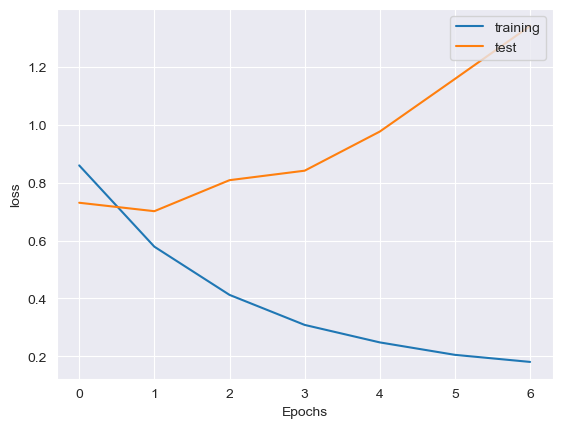

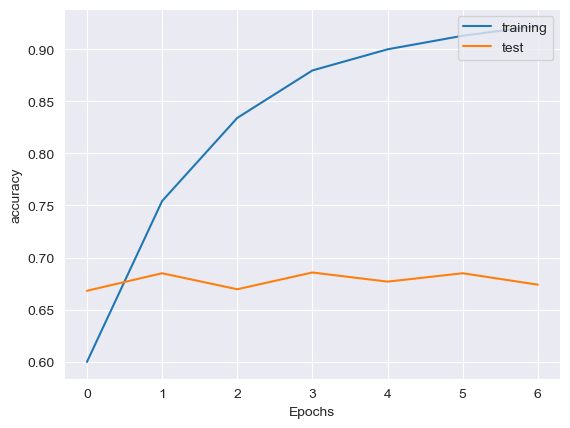

In [60]:
graph_model(history_lstm1, 'loss')
graph_model(history_lstm1, 'accuracy')

In [61]:
# LSTM model - Bidirectional
embed_dim=128

model_lstm2 = Sequential()
model_lstm2.add(layers.Embedding(input_dim = vocab_size,
                    output_dim = 128,
                    input_length = maxlen))
model_lstm2.add(layers.Bidirectional(layers.LSTM(embed_dim, return_sequences=True)))
model_lstm2.add(layers.GlobalMaxPool1D())
model_lstm2.add(layers.Dropout(0.2))
model_lstm2.add(layers.Dense(64, activation='relu'))
model_lstm2.add(layers.Dense(3, activation='softmax'))
          
model_lstm2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 128)           1147008   
                                                                 
 bidirectional (Bidirection  (None, 23, 256)           263168    
 al)                                                             
                                                                 
 global_max_pooling1d_1 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 3)                

In [62]:
history_lstm2, _, _, _ = predict(model_lstm2, 20, 32)

Epoch 1/20
243/243 [==============================] - 12s 33ms/step - loss: 0.8408 - accuracy: 0.6017 - val_loss: 0.6790 - val_accuracy: 0.7047
Epoch 2/20
243/243 [==============================] - 8s 35ms/step - loss: 0.5434 - accuracy: 0.7680 - val_loss: 0.6945 - val_accuracy: 0.6806
Epoch 3/20
243/243 [==============================] - 8s 33ms/step - loss: 0.3621 - accuracy: 0.8581 - val_loss: 0.7628 - val_accuracy: 0.6791
Epoch 4/20
243/243 [==============================] - 8s 32ms/step - loss: 0.2648 - accuracy: 0.8945 - val_loss: 0.9092 - val_accuracy: 0.6725
Epoch 5/20
243/243 [==============================] - 9s 39ms/step - loss: 0.2104 - accuracy: 0.9143 - val_loss: 0.9954 - val_accuracy: 0.6813
Epoch 6/20
32/32 [==============================] - 0s 10ms/step


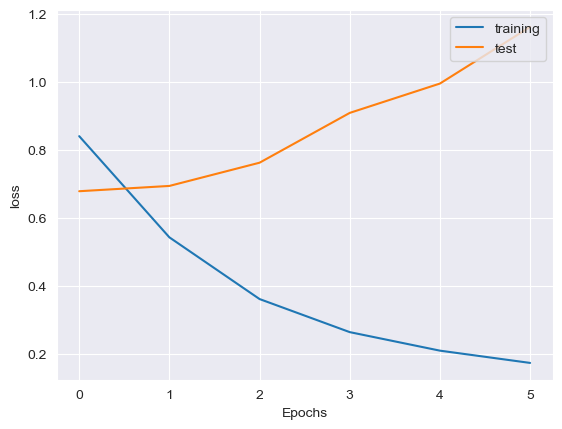

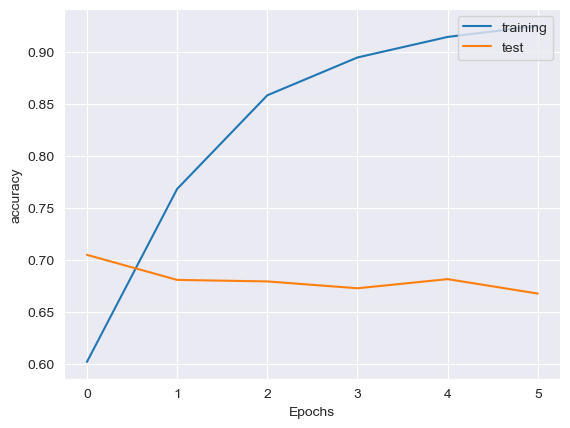

In [63]:
graph_model(history_lstm2, 'loss')
graph_model(history_lstm2, 'accuracy')

#### Observation

We can see our LSTM model hugely suffers from overfitting problem. Futhermore, current validation accuracy is on the same level as classical model such as Naive Bayes or Random Forest. 
In the next, let's try to import a pretrained model and see if we can get better result.

In [64]:
# Use GLOVE pretrained model
import os


embeddings_index = {}
f = open(os.path.join( 'glove.6B.100d.txt'), encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

400000it [00:11, 34266.41it/s]


In [65]:
print(f'found {len(embeddings_index)} word vectors.')

found 400000 word vectors.


This is huge list, we need to create a matrix containing words for our vocabulary

In [66]:
# Create a weight matrix for work vocabulary from our training set

embedding_matrix = np.zeros((vocab_size, 100))  # 100 for 100-dimensional version  
for word, i in tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 8960/8960 [00:00<00:00, 360267.69it/s]


We chose 100-dimensional version, so the Embedding layer must be defined with output_dim set to 100.
Also, we do not want to update the learned word weights in this model, therefore we will set the trainable attribute for the model to be False.

In [67]:
# LSTM model - Bidirectional with GLOVE embedding
embed_dim=128

model_lstm3 = Sequential()
model_lstm3.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                     weights=[embedding_matrix], 
                     input_length=maxlen, trainable=False))
model_lstm3.add(layers.Bidirectional(layers.LSTM(embed_dim, return_sequences=True)))
model_lstm3.add(layers.GlobalMaxPool1D())
model_lstm3.add(layers.Dropout(0.2))
model_lstm3.add(layers.Dense(64, activation='relu'))
model_lstm3.add(layers.Dense(3, activation='softmax'))
          
model_lstm3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 23, 100)           896100    
                                                                 
 bidirectional_1 (Bidirecti  (None, 23, 256)           234496    
 onal)                                                           
                                                                 
 global_max_pooling1d_2 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 3)                

In [68]:
hist_lstm3, train_lstm3, val_lstm3, test_lstm3 = predict(model_lstm3, 20, 32)

Epoch 1/20
243/243 [==============================] - 11s 31ms/step - loss: 0.8458 - accuracy: 0.6026 - val_loss: 0.7462 - val_accuracy: 0.6667
Epoch 2/20
243/243 [==============================] - 6s 23ms/step - loss: 0.7136 - accuracy: 0.6665 - val_loss: 0.6978 - val_accuracy: 0.6806
Epoch 3/20
243/243 [==============================] - 7s 27ms/step - loss: 0.6432 - accuracy: 0.7116 - val_loss: 0.6679 - val_accuracy: 0.7018
Epoch 4/20
243/243 [==============================] - 6s 26ms/step - loss: 0.5920 - accuracy: 0.7403 - val_loss: 0.6571 - val_accuracy: 0.7047
Epoch 5/20
243/243 [==============================] - 6s 26ms/step - loss: 0.5433 - accuracy: 0.7638 - val_loss: 0.6334 - val_accuracy: 0.7251
Epoch 6/20
243/243 [==============================] - 6s 24ms/step - loss: 0.4983 - accuracy: 0.7852 - val_loss: 0.6452 - val_accuracy: 0.7171
Epoch 7/20
243/243 [==============================] - 6s 26ms/step - loss: 0.4560 - accuracy: 0.8052 - val_loss: 0.6557 - val_accuracy: 0.712

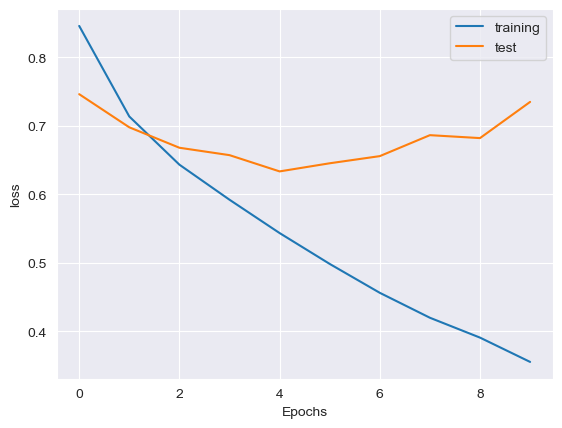

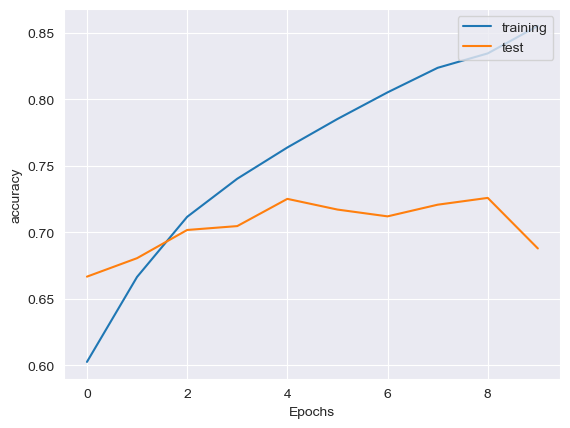

In [69]:
graph_model(hist_lstm3, 'loss')
graph_model(hist_lstm3, 'accuracy')

Even with the pretrained model, the LSTM is not reducing the overfitting of the data. In the next cell, we will try to optimize the model architecture. We will start by increasing drop_out parameters

In [70]:
# LSTM model - Bidirectional with GLOVE embedding
embed_dim=128

model_lstm4 = Sequential()
model_lstm4.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                     weights=[embedding_matrix], 
                     input_length=maxlen, trainable=False))
model_lstm4.add(layers.Dropout(0.4))
model_lstm4.add(layers.Bidirectional(layers.LSTM(embed_dim, return_sequences=True)))
model_lstm4.add(layers.GlobalMaxPool1D())
model_lstm4.add(layers.Dropout(0.2))
model_lstm4.add(layers.Dense(64, activation='relu'))
model_lstm4.add(layers.Dense(3, activation='softmax'))
          
model_lstm4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 23, 100)           896100    
                                                                 
 dropout_3 (Dropout)         (None, 23, 100)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 23, 256)           234496    
 onal)                                                           
                                                                 
 global_max_pooling1d_3 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [71]:
hist_lstm4, train_lstm4, val_lstm4, _ = predict(model_lstm4, 20, 32)

Epoch 1/20
243/243 [==============================] - 9s 24ms/step - loss: 0.8918 - accuracy: 0.5712 - val_loss: 0.7883 - val_accuracy: 0.6513
Epoch 2/20
243/243 [==============================] - 7s 30ms/step - loss: 0.7916 - accuracy: 0.6313 - val_loss: 0.7328 - val_accuracy: 0.6689
Epoch 3/20
243/243 [==============================] - 8s 32ms/step - loss: 0.7466 - accuracy: 0.6452 - val_loss: 0.7208 - val_accuracy: 0.6784
Epoch 4/20
243/243 [==============================] - 8s 33ms/step - loss: 0.7139 - accuracy: 0.6690 - val_loss: 0.6962 - val_accuracy: 0.6725
Epoch 5/20
243/243 [==============================] - 9s 35ms/step - loss: 0.6851 - accuracy: 0.6816 - val_loss: 0.6712 - val_accuracy: 0.7003
Epoch 6/20
243/243 [==============================] - 10s 42ms/step - loss: 0.6721 - accuracy: 0.6894 - val_loss: 0.6731 - val_accuracy: 0.6966
Epoch 7/20
243/243 [==============================] - 10s 42ms/step - loss: 0.6508 - accuracy: 0.7043 - val_loss: 0.6549 - val_accuracy: 0.71

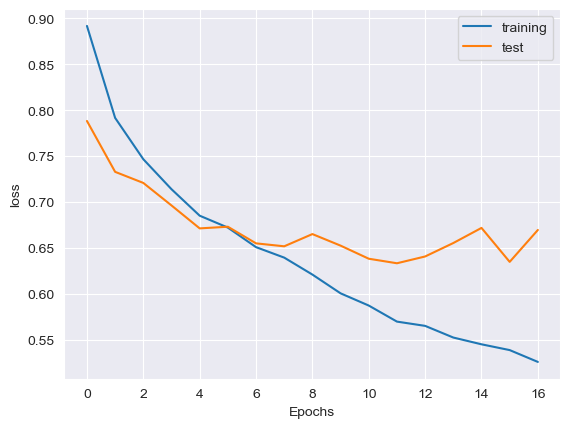

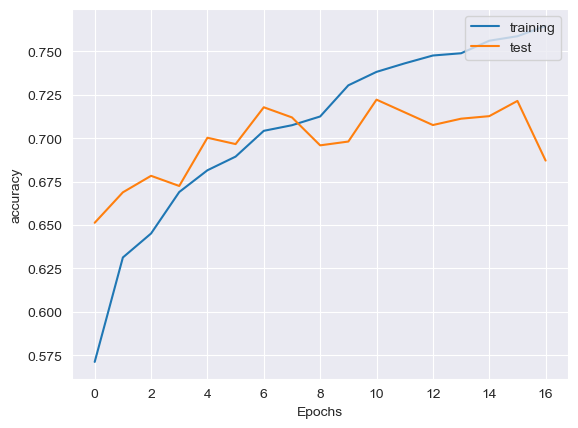

In [72]:
graph_model(hist_lstm4, 'loss')
graph_model(hist_lstm4, 'accuracy')

Increasing Dropout seems to help the predictions! Let see the classification report on training and validation result

In [73]:
def predict_df(y_true, y_pred):
    '''
    A simple function to put predicted results into a dataframe
    '''
    
    true_df = pd.DataFrame(y_true.idxmax(axis=1), columns=['true_emotion']).reset_index(drop=True)
    
    pred_df = pd.DataFrame(y_pred.argmax(axis=1), columns=['predicted'])
    pred_df['predicted'] = pred_df['predicted'].apply(lambda x: 'negative' if x==0 
                                                     else 'neutral' if x==1 
                                                     else 'positive' )
    
    merge_df = pd.merge(true_df, pred_df, left_index=True, right_index=True)
    
    print(classification_report(merge_df['true_emotion'], merge_df['predicted']))
    
    return merge_df

In [74]:
train_predict_df = predict_df(y_train, train_lstm4)
val_predict_df = predict_df(y_val, val_lstm4)

              precision    recall  f1-score   support

    negative       0.96      0.86      0.91      1368
     neutral       0.89      0.80      0.85      4109
    positive       0.69      0.86      0.77      2270

    accuracy                           0.83      7747
   macro avg       0.85      0.84      0.84      7747
weighted avg       0.84      0.83      0.83      7747

              precision    recall  f1-score   support

    negative       0.88      0.70      0.78       241
     neutral       0.78      0.67      0.72       726
    positive       0.52      0.71      0.60       401

    accuracy                           0.69      1368
   macro avg       0.72      0.69      0.70      1368
weighted avg       0.72      0.69      0.69      1368



The validation accuracy of has improved slightly, but in general it is still suffering training overfit. Next we will try to implement GRU network which seems to perform better for smaller datasets.

###  GRU

In [75]:
model_gru1 = Sequential()
model_gru1.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                     weights=[embedding_matrix], 
                     input_length=maxlen, trainable=False))
model_gru1.add(layers.Dropout(0.4))
model_gru1.add(layers.GRU(100))
model_gru1.add(layers.Flatten())
model_gru1.add(layers.Dropout(0.2))
model_gru1.add(layers.Dense(64, activation='relu'))
model_gru1.add(layers.Dense(3, activation='softmax'))

model_gru1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_gru1.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 23, 100)           896100    
                                                                 
 dropout_5 (Dropout)         (None, 23, 100)           0         
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                6464      
                                                                 
 dense_9 (Dense)             (None, 3)                

In [76]:
hist_gru1, train_gru1, val_gru1, test_gru1 = predict(model_gru1, 20, 32)

Epoch 1/20
243/243 [==============================] - 6s 15ms/step - loss: 0.9421 - accuracy: 0.5516 - val_loss: 0.8367 - val_accuracy: 0.6016
Epoch 2/20
243/243 [==============================] - 3s 12ms/step - loss: 0.8338 - accuracy: 0.5946 - val_loss: 0.8056 - val_accuracy: 0.6133
Epoch 3/20
243/243 [==============================] - 3s 14ms/step - loss: 0.7962 - accuracy: 0.6095 - val_loss: 0.7578 - val_accuracy: 0.6425
Epoch 4/20
243/243 [==============================] - 4s 17ms/step - loss: 0.7520 - accuracy: 0.6427 - val_loss: 0.7301 - val_accuracy: 0.6477
Epoch 5/20
243/243 [==============================] - 4s 18ms/step - loss: 0.7288 - accuracy: 0.6584 - val_loss: 0.7081 - val_accuracy: 0.6659
Epoch 6/20
243/243 [==============================] - 4s 15ms/step - loss: 0.7138 - accuracy: 0.6650 - val_loss: 0.6798 - val_accuracy: 0.6886
Epoch 7/20
243/243 [==============================] - 4s 16ms/step - loss: 0.6936 - accuracy: 0.6797 - val_loss: 0.6927 - val_accuracy: 0.6827

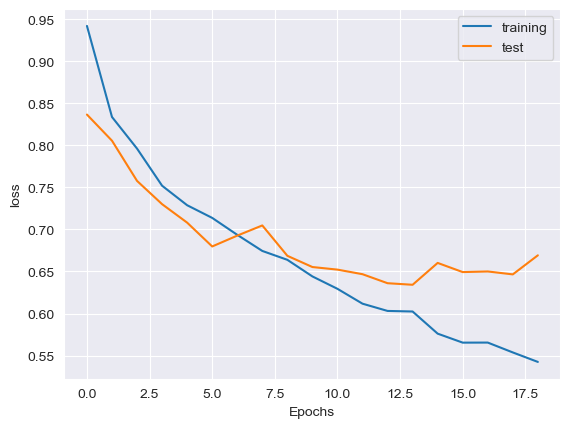

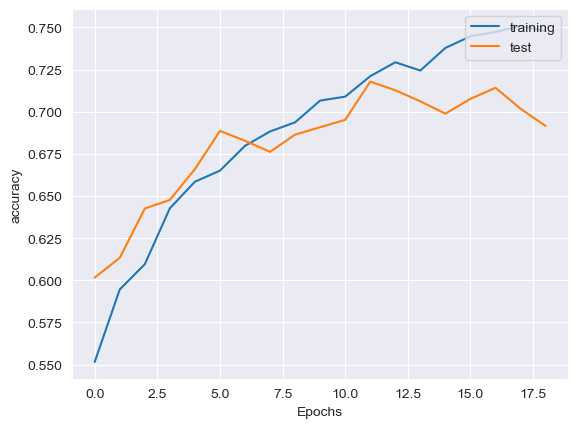

In [77]:
graph_model(hist_gru1, 'loss')
graph_model(hist_gru1, 'accuracy')

In [78]:
train_predict_df = predict_df(y_train, train_gru1)
val_predict_df = predict_df(y_val, val_gru1)

              precision    recall  f1-score   support

    negative       0.90      0.87      0.88      1368
     neutral       0.86      0.79      0.82      4109
    positive       0.68      0.81      0.74      2270

    accuracy                           0.81      7747
   macro avg       0.82      0.82      0.82      7747
weighted avg       0.82      0.81      0.81      7747

              precision    recall  f1-score   support

    negative       0.80      0.72      0.76       241
     neutral       0.77      0.69      0.73       726
    positive       0.54      0.68      0.60       401

    accuracy                           0.69      1368
   macro avg       0.70      0.70      0.70      1368
weighted avg       0.71      0.69      0.70      1368



We can see, there is not much of the difference in model performance betwen LSTM and GRU. We have noticed a strong imbalance in the class label in our dataset. Next, we will evaluate, if providing weights in the fit method will help to reduce the overfit.

###  Imbalanced Class 

In [79]:
df.emotion.value_counts()/df.shape[0]

emotion
neutral     0.530411
positive    0.293049
negative    0.176540
Name: count, dtype: float64

In [80]:
y_ohe_numpy = y_ohe.to_numpy()

In [82]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_integers = np.argmax(y_ohe_numpy, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))

In [83]:
d_class_weights

{0: 1.8881431767337808, 1: 0.6284437825763217, 2: 1.137466307277628}

In [84]:
# Define callbacks and save final model
def predict_w(model, epochs, batch_size, weights):
    early_stop = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model_m.h5', monitor='val_loss',
                            save_best_only=True)]

    history = model.fit(X_train_seq, y_train, 
                     batch_size=batch_size, epochs=epochs, verbose=1, 
                     validation_data=(X_val_seq, y_val),
                     callbacks=early_stop,
                     class_weight=weights)
                               
    graph_model(history, 'loss')
    graph_model(history, 'accuracy')
    
    train_prediction = model.predict(X_train_seq, batch_size=batch_size)
    val_prediction = model.predict(X_val_seq, batch_size=batch_size)
    test_prediction = model.predict(X_test_seq, batch_size=batch_size)    
    
    return history, train_prediction, val_prediction, test_prediction 

In [85]:
# LSTM model - Bidirectional with GLOVE embedding
embed_dim=128

model_lstm5 = Sequential()
model_lstm5.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                     weights=[embedding_matrix], 
                     input_length=maxlen, trainable=False))
model_lstm5.add(layers.Dropout(0.4))
model_lstm5.add(layers.Bidirectional(layers.LSTM(embed_dim, return_sequences=True)))
model_lstm5.add(layers.GlobalMaxPool1D())
model_lstm5.add(layers.Dropout(0.2))
model_lstm5.add(layers.Dense(64, activation='relu'))
model_lstm5.add(layers.Dense(3, activation='softmax'))
          
model_lstm5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm5.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 23, 100)           896100    
                                                                 
 dropout_7 (Dropout)         (None, 23, 100)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 23, 256)           234496    
 onal)                                                           
                                                                 
 global_max_pooling1d_4 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 64)               

Epoch 1/20
243/243 [==============================] - 10s 25ms/step - loss: 0.9373 - accuracy: 0.4877 - val_loss: 0.8679 - val_accuracy: 0.5431
Epoch 2/20
243/243 [==============================] - 7s 30ms/step - loss: 0.8242 - accuracy: 0.5673 - val_loss: 0.8236 - val_accuracy: 0.5870
Epoch 3/20
243/243 [==============================] - 7s 31ms/step - loss: 0.7706 - accuracy: 0.6009 - val_loss: 0.8574 - val_accuracy: 0.5314
Epoch 4/20
243/243 [==============================] - 6s 25ms/step - loss: 0.7443 - accuracy: 0.6230 - val_loss: 0.8014 - val_accuracy: 0.5892
Epoch 5/20
243/243 [==============================] - 7s 30ms/step - loss: 0.7004 - accuracy: 0.6446 - val_loss: 0.7446 - val_accuracy: 0.6031
Epoch 6/20
243/243 [==============================] - 6s 24ms/step - loss: 0.6824 - accuracy: 0.6525 - val_loss: 0.6962 - val_accuracy: 0.6806
Epoch 7/20
243/243 [==============================] - 7s 28ms/step - loss: 0.6546 - accuracy: 0.6698 - val_loss: 0.6791 - val_accuracy: 0.682

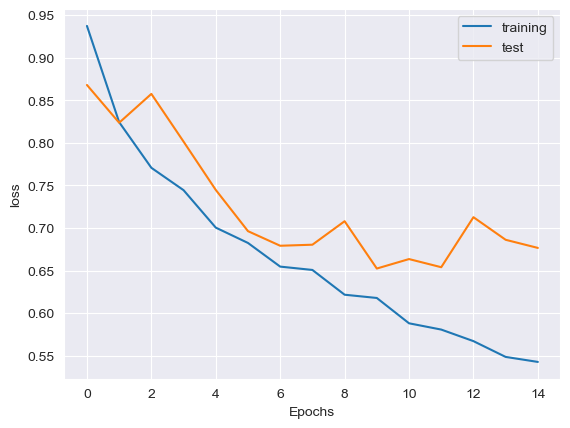

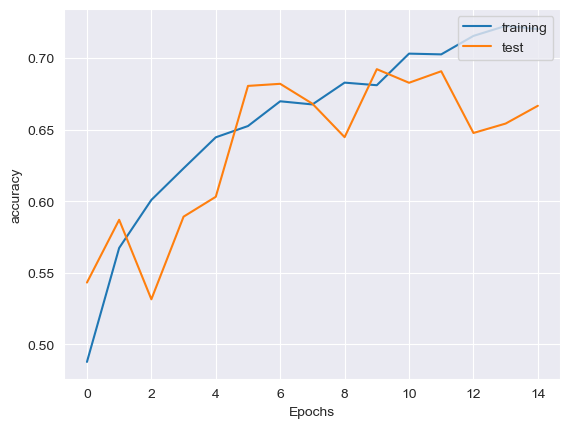

32/32 [==============================] - 0s 9ms/step


In [86]:
hist_lstm5, train_lstm5, val_lstm5, _ = predict_w(model_lstm5, 20, 32, d_class_weights)

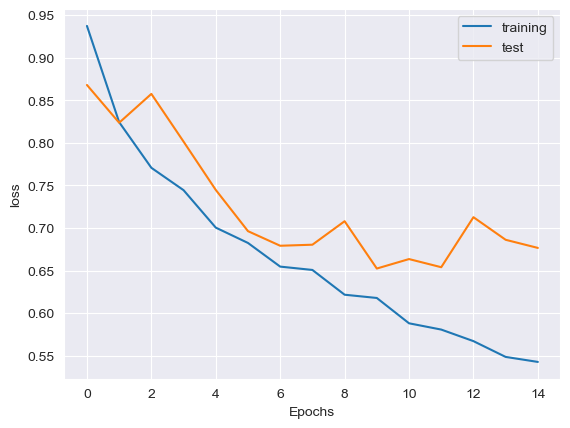

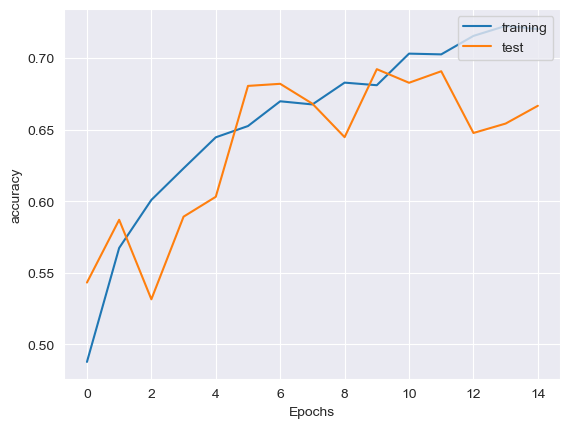

In [87]:
graph_model(hist_lstm5, 'loss')
graph_model(hist_lstm5, 'accuracy')

In [88]:
# GRU 
model_gru2 = Sequential()
model_gru2.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                     weights=[embedding_matrix], 
                     input_length=maxlen, trainable=False))
model_gru2.add(layers.Dropout(0.4))
model_gru2.add(layers.GRU(100))
model_gru2.add(layers.Flatten())
model_gru2.add(layers.Dropout(0.2))
model_gru2.add(layers.Dense(64, activation='relu'))
model_gru2.add(layers.Dense(3, activation='softmax'))

model_gru2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_gru2.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 23, 100)           896100    
                                                                 
 dropout_9 (Dropout)         (None, 23, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                6464      
                                                                 
 dense_13 (Dense)            (None, 3)                

Epoch 1/20
243/243 [==============================] - 6s 14ms/step - loss: 1.0266 - accuracy: 0.3720 - val_loss: 0.9612 - val_accuracy: 0.3852
Epoch 2/20
243/243 [==============================] - 3s 13ms/step - loss: 0.8821 - accuracy: 0.4745 - val_loss: 0.8592 - val_accuracy: 0.5687
Epoch 3/20
243/243 [==============================] - 4s 18ms/step - loss: 0.8476 - accuracy: 0.5154 - val_loss: 0.8814 - val_accuracy: 0.4788
Epoch 4/20
243/243 [==============================] - 3s 14ms/step - loss: 0.7941 - accuracy: 0.5569 - val_loss: 0.7905 - val_accuracy: 0.5965
Epoch 5/20
243/243 [==============================] - 4s 16ms/step - loss: 0.7699 - accuracy: 0.5853 - val_loss: 0.7638 - val_accuracy: 0.6250
Epoch 6/20
243/243 [==============================] - 3s 14ms/step - loss: 0.7374 - accuracy: 0.6111 - val_loss: 0.7545 - val_accuracy: 0.6228
Epoch 7/20
243/243 [==============================] - 4s 16ms/step - loss: 0.7161 - accuracy: 0.6257 - val_loss: 0.7596 - val_accuracy: 0.6221

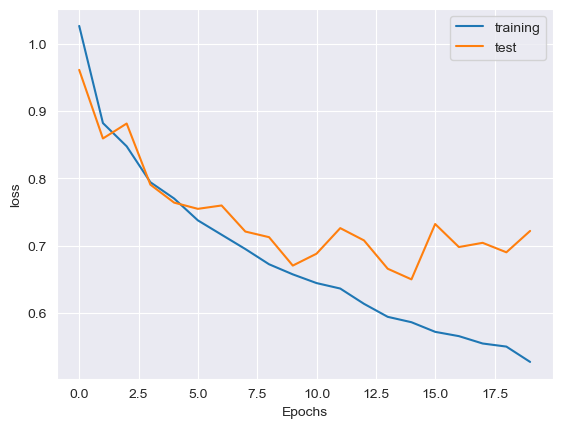

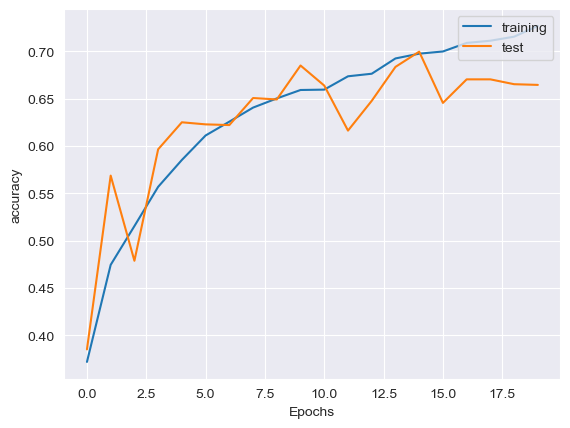

32/32 [==============================] - 0s 5ms/step


In [89]:
hist_gru2, train_gru2, val_gru2, test_gru2 = predict_w(model_gru2, 20, 32, d_class_weights)

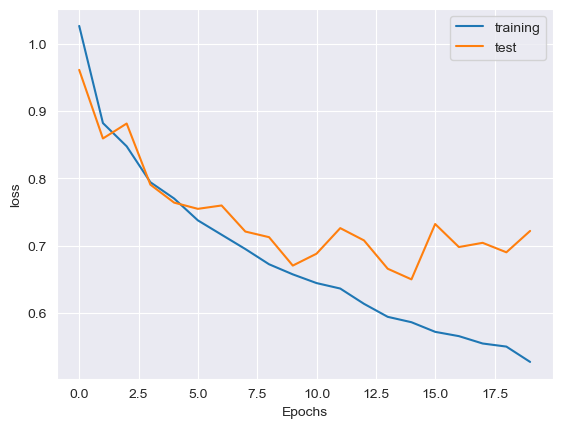

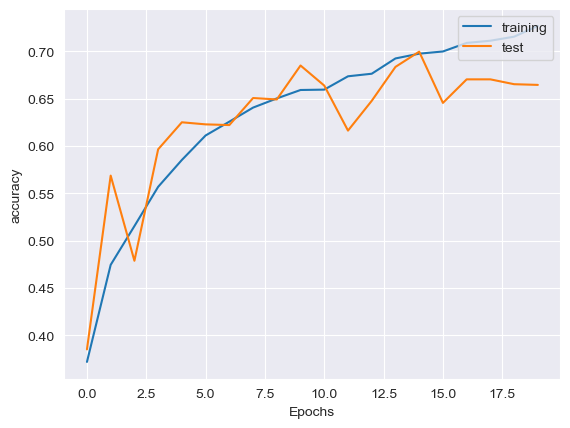

In [90]:
graph_model(hist_gru2, 'loss')
graph_model(hist_gru2, 'accuracy')

In [91]:
train_predict_df = predict_df(y_train, train_gru2)
val_predict_df = predict_df(y_val, val_gru2)


              precision    recall  f1-score   support

    negative       0.87      0.94      0.90      1368
     neutral       0.89      0.66      0.76      4109
    positive       0.61      0.86      0.71      2270

    accuracy                           0.77      7747
   macro avg       0.79      0.82      0.79      7747
weighted avg       0.80      0.77      0.77      7747

              precision    recall  f1-score   support

    negative       0.79      0.75      0.77       241
     neutral       0.81      0.58      0.68       726
    positive       0.49      0.77      0.60       401

    accuracy                           0.66      1368
   macro avg       0.70      0.70      0.68      1368
weighted avg       0.72      0.66      0.67      1368



Even though we add class weights, we do not see being improvement in the model performance.

### Final Modelling

In [92]:
def create_model(model_type, vocab_size, maxlen, embed_dim):
    '''
    Create and return a compiled model
    '''
    
    if model_type == 'lstm':
        
        model = Sequential()
        model.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                             weights=[embedding_matrix], 
                             input_length=maxlen, trainable=False))
        model.add(layers.Dropout(0.4))
        model.add(layers.Bidirectional(layers.LSTM(embed_dim, return_sequences=True)))
        model.add(layers.GlobalMaxPool1D())
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(3, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    elif model_type == 'gru':
                   
        model = Sequential()
        model.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                             weights=[embedding_matrix], 
                             input_length=maxlen, trainable=False))
        model.add(layers.Dropout(0.4))
        model.add(layers.GRU(100))
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(3, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [93]:
final_model = create_model('gru', vocab_size, maxlen, embed_dim=128)
final_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 23, 100)           896100    
                                                                 
 dropout_11 (Dropout)        (None, 23, 100)           0         
                                                                 
 gru_2 (GRU)                 (None, 100)               60600     
                                                                 
 flatten_2 (Flatten)         (None, 100)               0         
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                6464      
                                                                 
 dense_15 (Dense)            (None, 3)                

### Model Fit

In [94]:
checkpoint_path = 'final_model_weights/cp.{epoch:04d}.ckpt'

# Create a Model Check point
checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

history_final = final_model.fit(X_train_seq, y_train,
                          batch_size=32, 
                          epochs=20, 
                          verbose=1,
                          validation_data=(X_val_seq, y_val),
                          callbacks= [checkpoint]
                         )
train_prediction = final_model.predict(X_train_seq, batch_size=32)
val_prediction = final_model.predict(X_val_seq, batch_size=32)
test_prediction = final_model.predict(X_test_seq, batch_size=32)  

Epoch 1/20
242/243 [============================>.] - ETA: 0s - loss: 0.9286 - accuracy: 0.5581
Epoch 1: val_loss improved from inf to 0.82521, saving model to final_model_weights\cp.0001.ckpt
243/243 [==============================] - 5s 13ms/step - loss: 0.9285 - accuracy: 0.5582 - val_loss: 0.8252 - val_accuracy: 0.6060
Epoch 2/20
240/243 [============================>.] - ETA: 0s - loss: 0.8375 - accuracy: 0.6036
Epoch 2: val_loss improved from 0.82521 to 0.79270, saving model to final_model_weights\cp.0002.ckpt
243/243 [==============================] - 3s 13ms/step - loss: 0.8371 - accuracy: 0.6038 - val_loss: 0.7927 - val_accuracy: 0.6096
Epoch 3/20
241/243 [============================>.] - ETA: 0s - loss: 0.7945 - accuracy: 0.6144
Epoch 3: val_loss improved from 0.79270 to 0.77681, saving model to final_model_weights\cp.0003.ckpt
243/243 [==============================] - 4s 15ms/step - loss: 0.7943 - accuracy: 0.6146 - val_loss: 0.7768 - val_accuracy: 0.6228
Epoch 4/20
241/24

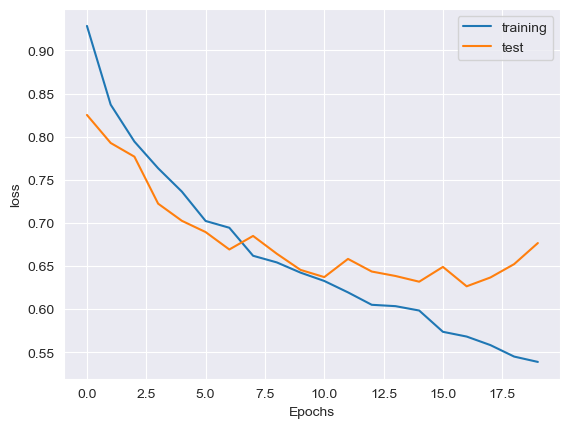

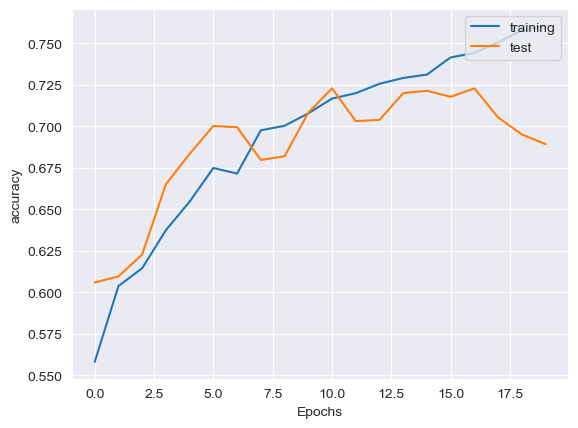

In [95]:
graph_model(history_final, 'loss')
graph_model(history_final, 'accuracy')

In [54]:
# Look inside save folder.
# sorted(os.listdir('final_model_weights'))

### Prediction

In [96]:
def evaluate_nn(model, X_test, y_test):
    """Print model accuracy on test set."""
    
    loss, acc = model.evaluate(X_test, y_test)
    print(f'Model Accuracy:\n\t{round(acc, 3)}')

    
# Evaluate model
evaluate_nn(final_model, X_test_seq, y_test)

32/32 [==============================] - 0s 7ms/step - loss: 0.6989 - accuracy: 0.6930
Model Accuracy:
	0.693


In [97]:
test_prediction = final_model.predict(X_test_seq, batch_size=32)  

32/32 [==============================] - 0s 7ms/step


In [98]:
test_predict_df = predict_df(y_test, test_prediction)

              precision    recall  f1-score   support

    negative       0.86      0.60      0.71       179
     neutral       0.74      0.73      0.74       537
    positive       0.56      0.67      0.61       297

    accuracy                           0.69      1013
   macro avg       0.72      0.67      0.69      1013
weighted avg       0.71      0.69      0.70      1013



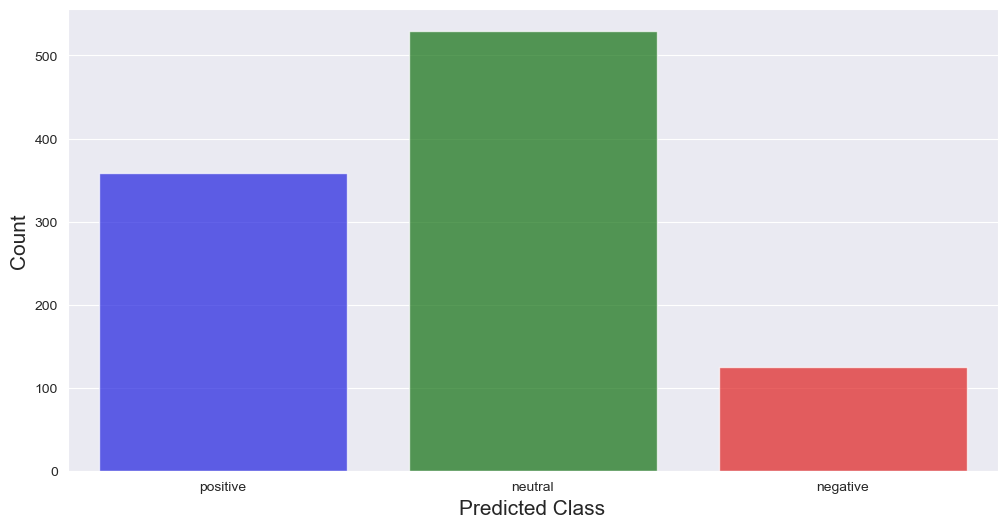

In [99]:
fig = plt.figure(figsize=(12,6))
colors = ['b']
sns.countplot(x='predicted', data=test_predict_df, 
              palette={'positive':'b', 'negative':'r', 'neutral':'g'}, alpha=0.7)
plt.xlabel("Predicted Class", fontsize=15)
plt.ylabel("Count", fontsize=15);

In [103]:
# load helper function
#from custom_confusion_matrix import create_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

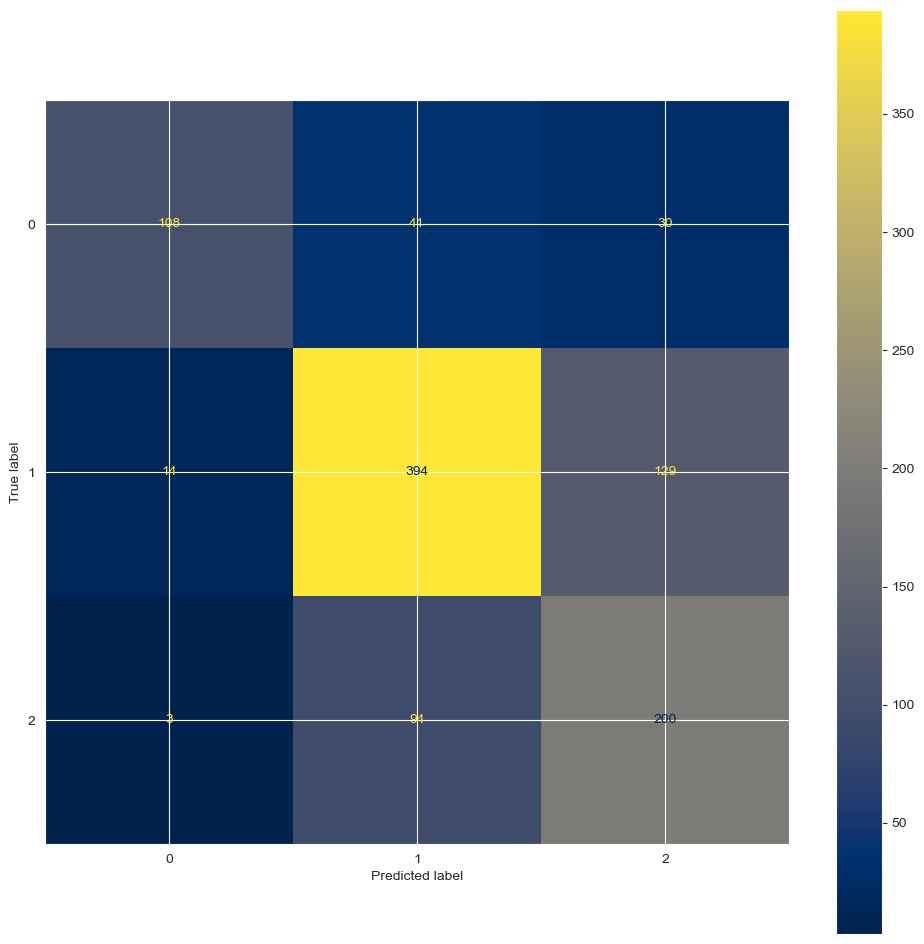

In [108]:
cm = confusion_matrix(test_predict_df.true_emotion, test_predict_df.predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap="cividis")
# Show the plot
plt.show()
#create_confusion_matrix(cm, figsize=(8,6), cbar=True)

In [109]:
# Examples of Test Prediction
X_test_orig = X_test.copy(deep=True)
X_test_orig.reset_index(drop=True, inplace=True)
X_test_orig = pd.DataFrame(X_test_orig.values, columns=['tweet'])
X_test_pred_merge = pd.merge(X_test_orig, test_predict_df, left_index=True, right_index=True)
X_test_pred_merge.head()

,tweet,true_emotion,predicted
0,haha awesomely rad ipad app hollergram via,positive,positive
1,what are you talking about back all the time,negative,neutral
2,talking about how mobile phones google earth e...,neutral,neutral
3,tweet this register for exclusive passes event...,neutral,neutral
4,thanks will keep mind tho have lately been unh...,negative,negative


In [110]:
print(X_test_pred_merge['tweet'][5])
print(X_test_pred_merge['true_emotion'][5])
print(X_test_pred_merge['predicted'][5])

interrupt your regularly scheduled geek programming with big news google circles
positive
neutral


In [111]:
print(X_test_pred_merge['tweet'][100])
print(X_test_pred_merge['true_emotion'][100])
print(X_test_pred_merge['predicted'][100])

anybody seen the 6th apple store yet
neutral
neutral


In [112]:
print(X_test_pred_merge['tweet'][700])
print(X_test_pred_merge['true_emotion'][700])
print(X_test_pred_merge['predicted'][700])

apple the most elegant fascist company america flipboard
negative
negative


In [113]:
print(X_test_pred_merge['tweet'][900])
print(X_test_pred_merge['true_emotion'][900])
print(X_test_pred_merge['predicted'][900])

windows the scarborough building corner 6th amp congress blacked out apple pop store being born welivehere
positive
neutral


In [114]:
X_test_pred_merge.head()

,tweet,true_emotion,predicted
0,haha awesomely rad ipad app hollergram via,positive,positive
1,what are you talking about back all the time,negative,neutral
2,talking about how mobile phones google earth e...,neutral,neutral
3,tweet this register for exclusive passes event...,neutral,neutral
4,thanks will keep mind tho have lately been unh...,negative,negative


In [116]:
from wordcloud import WordCloud

In [117]:
def create_wordcloud(df, col):
    wordcloud = WordCloud(background_color='black').generate(str(col))
    plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
    plt.axis("off")
    plt.show()  

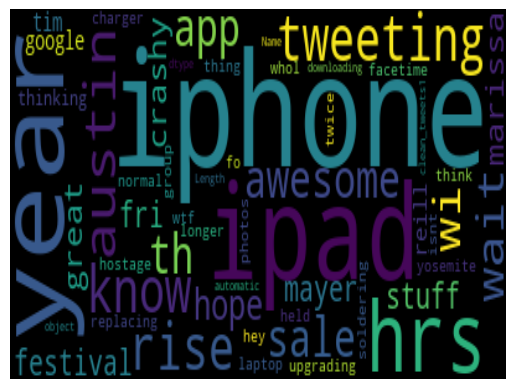

In [118]:
create_wordcloud(df.loc[df['emotion']=='negative'], df['clean_tweets1'])

It is notable to observe the tweet 'crashy' for the negative tweets! It is very strong behaviour of a product that can drive negative sentiment towards it.

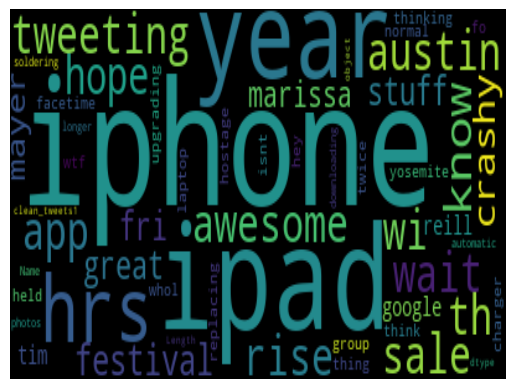

In [119]:
create_wordcloud(df.loc[df['emotion']=='positive'], df['clean_tweets1'])

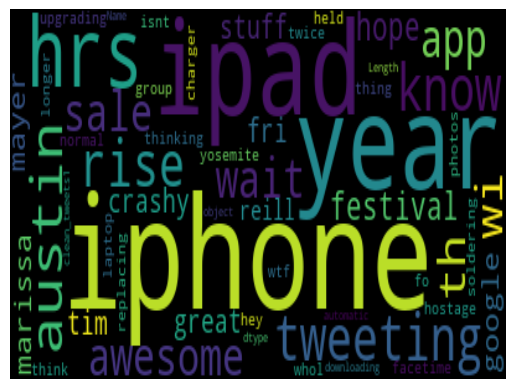

In [120]:
create_wordcloud(df.loc[df['emotion']=='neutral'], df['clean_tweets1'])

## Conclusion